In [1]:
import numpy as np
import torch, torchaudio
import whisper #pip install openai-whisper
import matplotlib.pyplot as plt
import matplotlib

# asr

In [2]:
model = whisper.load_model("medium")
audio = whisper.load_audio('wav/audio3.wav')
mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)).cuda()
options = whisper.DecodingOptions(beam_size=3)
result = whisper.decode(model, mel, options)
txt = result.text
print(txt)

Francia, Suiza y Hungría ya hicieron causa común.


# plot attention

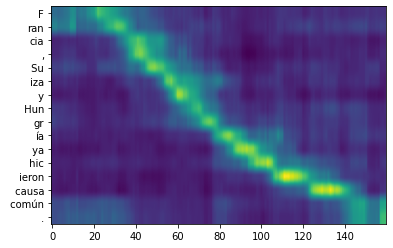

In [3]:
from whisper.tokenizer import get_tokenizer
tokenizer = get_tokenizer(model.is_multilingual)
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE


tokens = torch.tensor(
    [
        *tokenizer.sot_sequence,
        tokenizer.timestamp_begin,
    ] + tokenizer.encode(txt) + [
        tokenizer.timestamp_begin + len(audio) // AUDIO_SAMPLES_PER_TOKEN,
        tokenizer.eot,
    ]
).cuda()

QKs = [None] * model.dims.n_text_layer
for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )


with torch.no_grad():
    logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

from scipy.ndimage import median_filter
medfilt_width = 7
qk_scale = 1.0
weights = torch.cat(QKs)  # layers * heads * tokens * frames    
weights = weights[:, :, :, : len(audio) // AUDIO_SAMPLES_PER_TOKEN].cpu()
weights = median_filter(weights, (1, 1, 1, medfilt_width))
weights = torch.tensor(weights * qk_scale).softmax(dim=-1)

w = weights / weights.norm(dim=-2, keepdim=True)
matrix = w[-6:].mean(axis=(0, 1))

import matplotlib.pyplot as plt
plt.imshow(matrix[4:-2,:],  aspect="auto", interpolation=None)
t_ = [tokenizer.decode([t,]) for t in tokens[4:-2]]
ax = plt.gca()    
ax.set_yticks(np.arange(len(t_)), t_)